<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Convert-date-cols-to-int-type" data-toc-modified-id="Convert-date-cols-to-int-type-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convert date cols to int type</a></span></li><li><span><a href="#Pull-out-the-dependant-variable-from-DF" data-toc-modified-id="Pull-out-the-dependant-variable-from-DF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pull out the dependant variable from DF</a></span></li><li><span><a href="#One-hot-encode-feature_1,-feature_2,-feature_3" data-toc-modified-id="One-hot-encode-feature_1,-feature_2,-feature_3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>One hot encode feature_1, feature_2, feature_3</a></span></li><li><span><a href="#proc_df-to-fill-NAs-&amp;-convert-to-categorical" data-toc-modified-id="proc_df-to-fill-NAs-&amp;-convert-to-categorical-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>proc_df to fill NAs &amp; convert to categorical</a></span></li><li><span><a href="#Base-model" data-toc-modified-id="Base-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Base model</a></span></li><li><span><a href="#Split-dataset" data-toc-modified-id="Split-dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Split dataset</a></span></li><li><span><a href="#Set-RF-samples-to-20k-and-print-the-base-score-with-optimised-params" data-toc-modified-id="Set-RF-samples-to-20k-and-print-the-base-score-with-optimised-params-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Set RF samples to 20k and print the base score with optimised params</a></span></li><li><span><a href="#Get-Feature-importance" data-toc-modified-id="Get-Feature-importance-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Get Feature importance</a></span></li><li><span><a href="#One-hot-encoding" data-toc-modified-id="One-hot-encoding-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>One hot encoding</a></span></li><li><span><a href="#Remove-redundant-features" data-toc-modified-id="Remove-redundant-features-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Remove redundant features</a></span></li><li><span><a href="#Compare-different-DFs" data-toc-modified-id="Compare-different-DFs-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Compare different DFs</a></span></li><li><span><a href="#Extrapolation" data-toc-modified-id="Extrapolation-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Extrapolation</a></span></li><li><span><a href="#Predict-if-it's-a-outlier" data-toc-modified-id="Predict-if-it's-a-outlier-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Predict if it's a outlier</a></span></li></ul></div>

1. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
from sklearn.metrics import mean_squared_error

In [3]:
train_df2 = feather.read_dataframe('train_df_proc_new_m')
test_df2 = feather.read_dataframe('test_df_proc_new_m')

In [4]:
df_raw = train_df2

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(DataFrameSummary(df_raw).summary().T)

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
first_active_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201917,75,0,0%,date
card_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201917,201917,0,0%,unique
feature_1,201917,0.0109302,0.0012591,0.00805849,0.0104794,0.0106099,0.0107116,0.0131446,201917,5,0,0%,numeric
feature_2,201917,0.0109302,0.00195247,0.00875212,0.00875212,0.0113848,0.0113848,0.0141664,201917,3,0,0%,numeric
feature_3,201917,0.0109302,0.000567402,0.0102828,0.0102828,0.0114275,0.0114275,0.0114275,201917,2,0,0%,bool
target,201917,-0.393636,3.8505,-33.2193,-0.88311,-0.0234369,0.765453,17.9651,201917,197110,0,0%,numeric
first_active_monthYear,201917,2016.51,0.788199,2011,2016,2017,2017,2018,201917,8,0,0%,numeric
first_active_monthMonth,201917,7.37874,3.34072,1,5,8,10,12,201917,12,0,0%,numeric
first_active_monthWeek,201917,30.9446,13.8454,1,22,31,44,53,201917,21,0,0%,numeric
first_active_monthDay,201917,1,0,1,1,1,1,1,201917,1,0,0%,constant


### Convert date cols to int type

In [13]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_amax','first_active_month','purchase_date_amin','purchase_date_amax_auth','purchase_date_amin_auth',
    'purchase_date_amax_n_auth','purchase_date_amin_n_auth']:
        df[f] = df[f].astype(np.int64) * 1e-9

### Pull out the dependant variable from DF

In [14]:
train_df2.shape, test_df2.shape, df_raw.shape

((201917, 339), (123623, 337), (201917, 339))

### One hot encode feature_1, feature_2, feature_3

In [15]:
train_df2 = pd.get_dummies(train_df2, columns=['feature_1', 'feature_2', 'feature_3'])
test_df2 = pd.get_dummies(test_df2, columns=['feature_1', 'feature_2', 'feature_3'])

In [17]:
train_df2.shape, test_df2.shape

((201917, 346), (123623, 344))

In [19]:
target = train_df2['target']

In [20]:
train_df2.drop('target', axis=1, inplace=True)

In [21]:
train_df2.drop('outliers', axis=1, inplace=True)

In [23]:
df_raw = train_df2.copy()
df_test_raw = test_df2.copy()

In [24]:
df_test_raw.shape, df_raw.shape

((123623, 344), (201917, 344))

### proc_df to fill NAs & convert to categorical

In [25]:
df_test, y_t, nas_t = proc_df(df_test_raw, max_n_cat=7, skip_flds=['card_id'])

In [26]:
df, y, nas = proc_df(df_raw, max_n_cat=7, skip_flds=['card_id'])

In [27]:
df.shape, df_test.shape

((201917, 538), (123623, 546))

### Base model 

In [28]:
def rmse(preds, target): 
    return np.sqrt(mean_squared_error(preds, target))

In [29]:
def print_score(m, x_trn, y_trn, x_val, y_val):
    res = [rmse(m.predict(x_trn), y_trn), rmse(m.predict(x_val), y_val),
                m.score(x_trn, y_trn), m.score(x_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [30]:
rf_args = dict({
    "n_estimators": 20, 
    "min_samples_leaf":3, 
    "max_features": 0.5, 
    "n_jobs":-1, 
    "oob_score":True
})

In [31]:
m = RandomForestRegressor(**rf_args)
m.fit(df, target)
m.score(df, target)
print_score(m, df, target.values, df, target.values)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[2.2747861628668926, 2.2747861628668926, 0.6509810142486188, 0.6509810142486188, -0.02341609845158188]


### Split dataset 

In [33]:
df.shape, df_test.shape

((201917, 538), (123623, 546))

In [34]:
np.int(np.floor(df.shape[0]*.8))

161533

In [35]:
def split_vals(a, n=.8):
    len_a = np.int(np.floor(a.shape[0]*n))
    return a[:len_a], a[len_a:]

In [36]:
x_trn, x_val = split_vals(df)

In [37]:
y_trn, y_val = split_vals(target)

In [38]:
[i.shape for i in [x_trn, y_trn, x_val, y_val]]

[(161533, 538), (161533,), (40384, 538), (40384,)]

### Set RF samples to 20k and print the base score with optimised params

In [39]:
set_rf_samples(20000)

In [40]:
m = RandomForestRegressor(**rf_args)
m.fit(x_trn, y_trn)
print_score(m, x_trn, y_trn.values, x_val, y_val.values)

[3.47382144924021, 3.79248846280667, 0.1785864965220536, 0.06403905679505062, 0.037168286382217475]


Base model score (20k samples) - 3.47382144924021, 3.79248846280667, 0.1785864965220536, 0.06403905679505062, 0.037168286382217475

### Get Feature importance

In [41]:
fi = rf_feat_importance(m, x_trn); fi[:10]

,cols,imp
165,month_diff_mean_auth,0.022378
170,category_1_Y_sum_auth,0.017108
154,month_lag_var_auth,0.012701
161,purchased_on_weekend_mean_auth,0.011884
38,purchase_amount_max,0.011277
158,purchase_date_ptp_auth,0.010247
166,month_diff_var_auth,0.009915
125,city_id_purchase_amount_min_auth,0.009787
197,purchase_amount_sum_std_auth,0.009052
157,purchase_date_amax_auth,0.009049


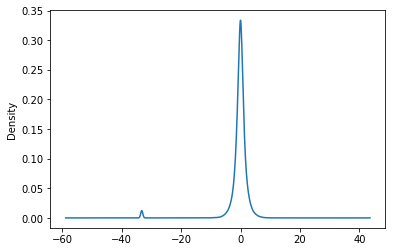

In [42]:
y_trn.plot.kde()

In [43]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(20,70), legend=False)

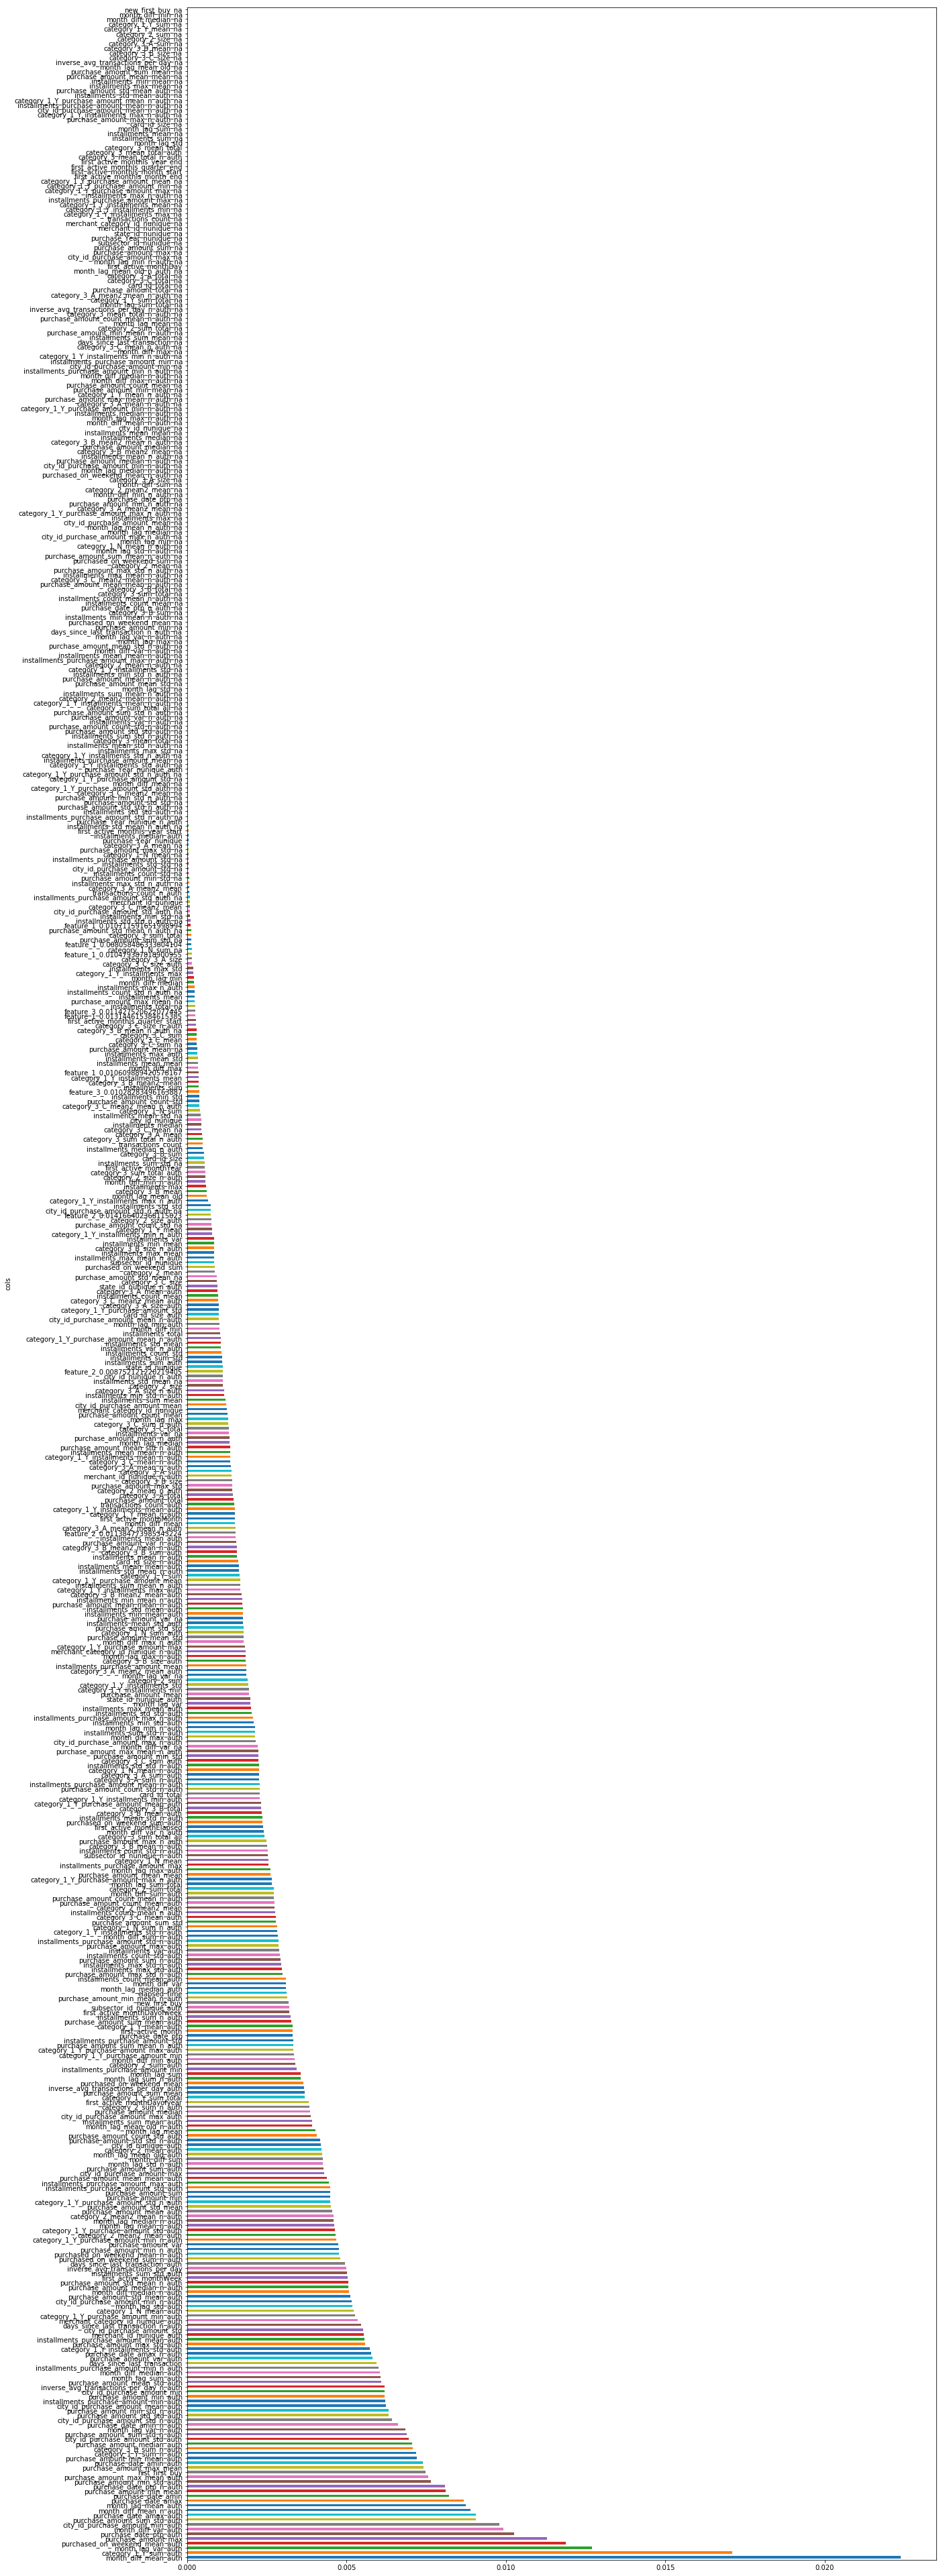

In [44]:
plot_fi(fi)

In [45]:
fi

,cols,imp
165,month_diff_mean_auth,0.022378
170,category_1_Y_sum_auth,0.017108
154,month_lag_var_auth,0.012701
161,purchased_on_weekend_mean_auth,0.011884
38,purchase_amount_max,0.011277
158,purchase_date_ptp_auth,0.010247
166,month_diff_var_auth,0.009915
125,city_id_purchase_amount_min_auth,0.009787
197,purchase_amount_sum_std_auth,0.009052
157,purchase_date_amax_auth,0.009049


In [46]:
display_all(fi.sort_values(ascending=False, by='imp')[:300])

,cols,imp
165,month_diff_mean_auth,0.022378
170,category_1_Y_sum_auth,0.017108
154,month_lag_var_auth,0.012701
161,purchased_on_weekend_mean_auth,0.011884
38,purchase_amount_max,0.011277
158,purchase_date_ptp_auth,0.010247
166,month_diff_var_auth,0.009915
125,city_id_purchase_amount_min_auth,0.009787
197,purchase_amount_sum_std_auth,0.009052
157,purchase_date_amax_auth,0.009049


In [77]:
to_keep = fi[fi.imp>0.0025]

In [78]:
to_keep.cols.shape

(151,)

In [79]:
df_keep = x_trn[to_keep.cols.values]

In [80]:
df_keep.shape

(161533, 151)

In [81]:
x_val_keep = x_val[to_keep.cols.values]
m = RandomForestRegressor(**rf_args)
m.fit(df_keep, y_trn)
print_score(m, df_keep, y_trn.values, x_val_keep, y_val.values)

[3.472910700074944, 3.800996774247901, 0.17901714824482118, 0.05983475656660231, 0.040307281350289825]


Base - 3.47382144924021, 3.79248846280667, 0.1785864965220536, 0.06403905679505062, 0.037168286382217475
fi>0.0025 - 3.472910700074944, 3.800996774247901, 0.17901714824482118, 0.05983475656660231, 0.040307281350289825 - 151 cols

In [82]:
fi = rf_feat_importance(m, df_keep)

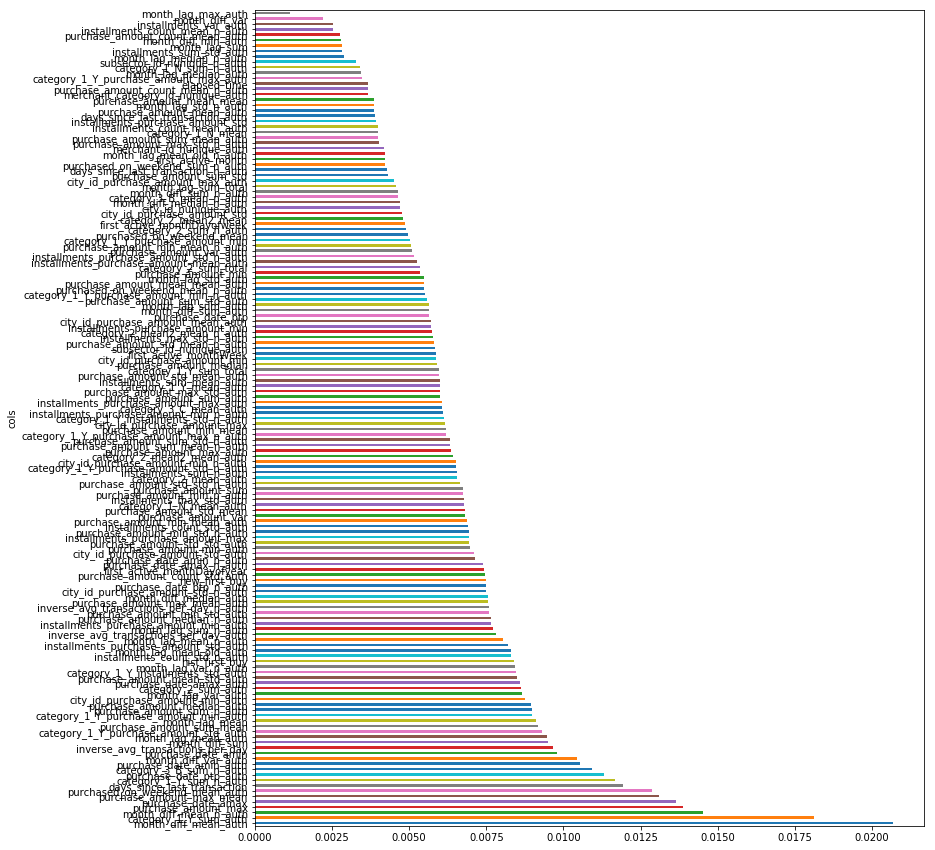

In [83]:
fi.plot('cols', 'imp', 'barh', figsize=(12,15), legend=False)

### One hot encoding

In [84]:
df_raw.shape, train_df2.shape

((201917, 344), (201917, 344))

In [86]:
df_not_hot, y, nas_hot = proc_df(df_raw, skip_flds=['card_id'])

In [87]:
df_not_hot_test, y, nas_hot = proc_df(df_test_raw, skip_flds=['card_id'])

In [89]:
df_hot = df_not_hot
df_hot_test = df_not_hot_test

In [90]:
df_hot.shape, df_hot_test.shape

((201917, 538), (123623, 546))

In [92]:
df_hot.shape

(201917, 538)

In [93]:
x_trn_h, x_val_h = split_vals(df_hot)
y_trn_h, y_val_h = split_vals(target)

In [94]:
m = RandomForestRegressor(**rf_args)
m.fit(x_trn_h, y_trn_h)
print_score(m, x_trn_h, y_trn_h.values, x_val_h, y_val_h.values)

[3.4825780999963984, 3.8081188738221035, 0.17444011366266843, 0.056308195440331166, 0.027540587367374192]


In [95]:
fi_hot = rf_feat_importance(m, df_hot)

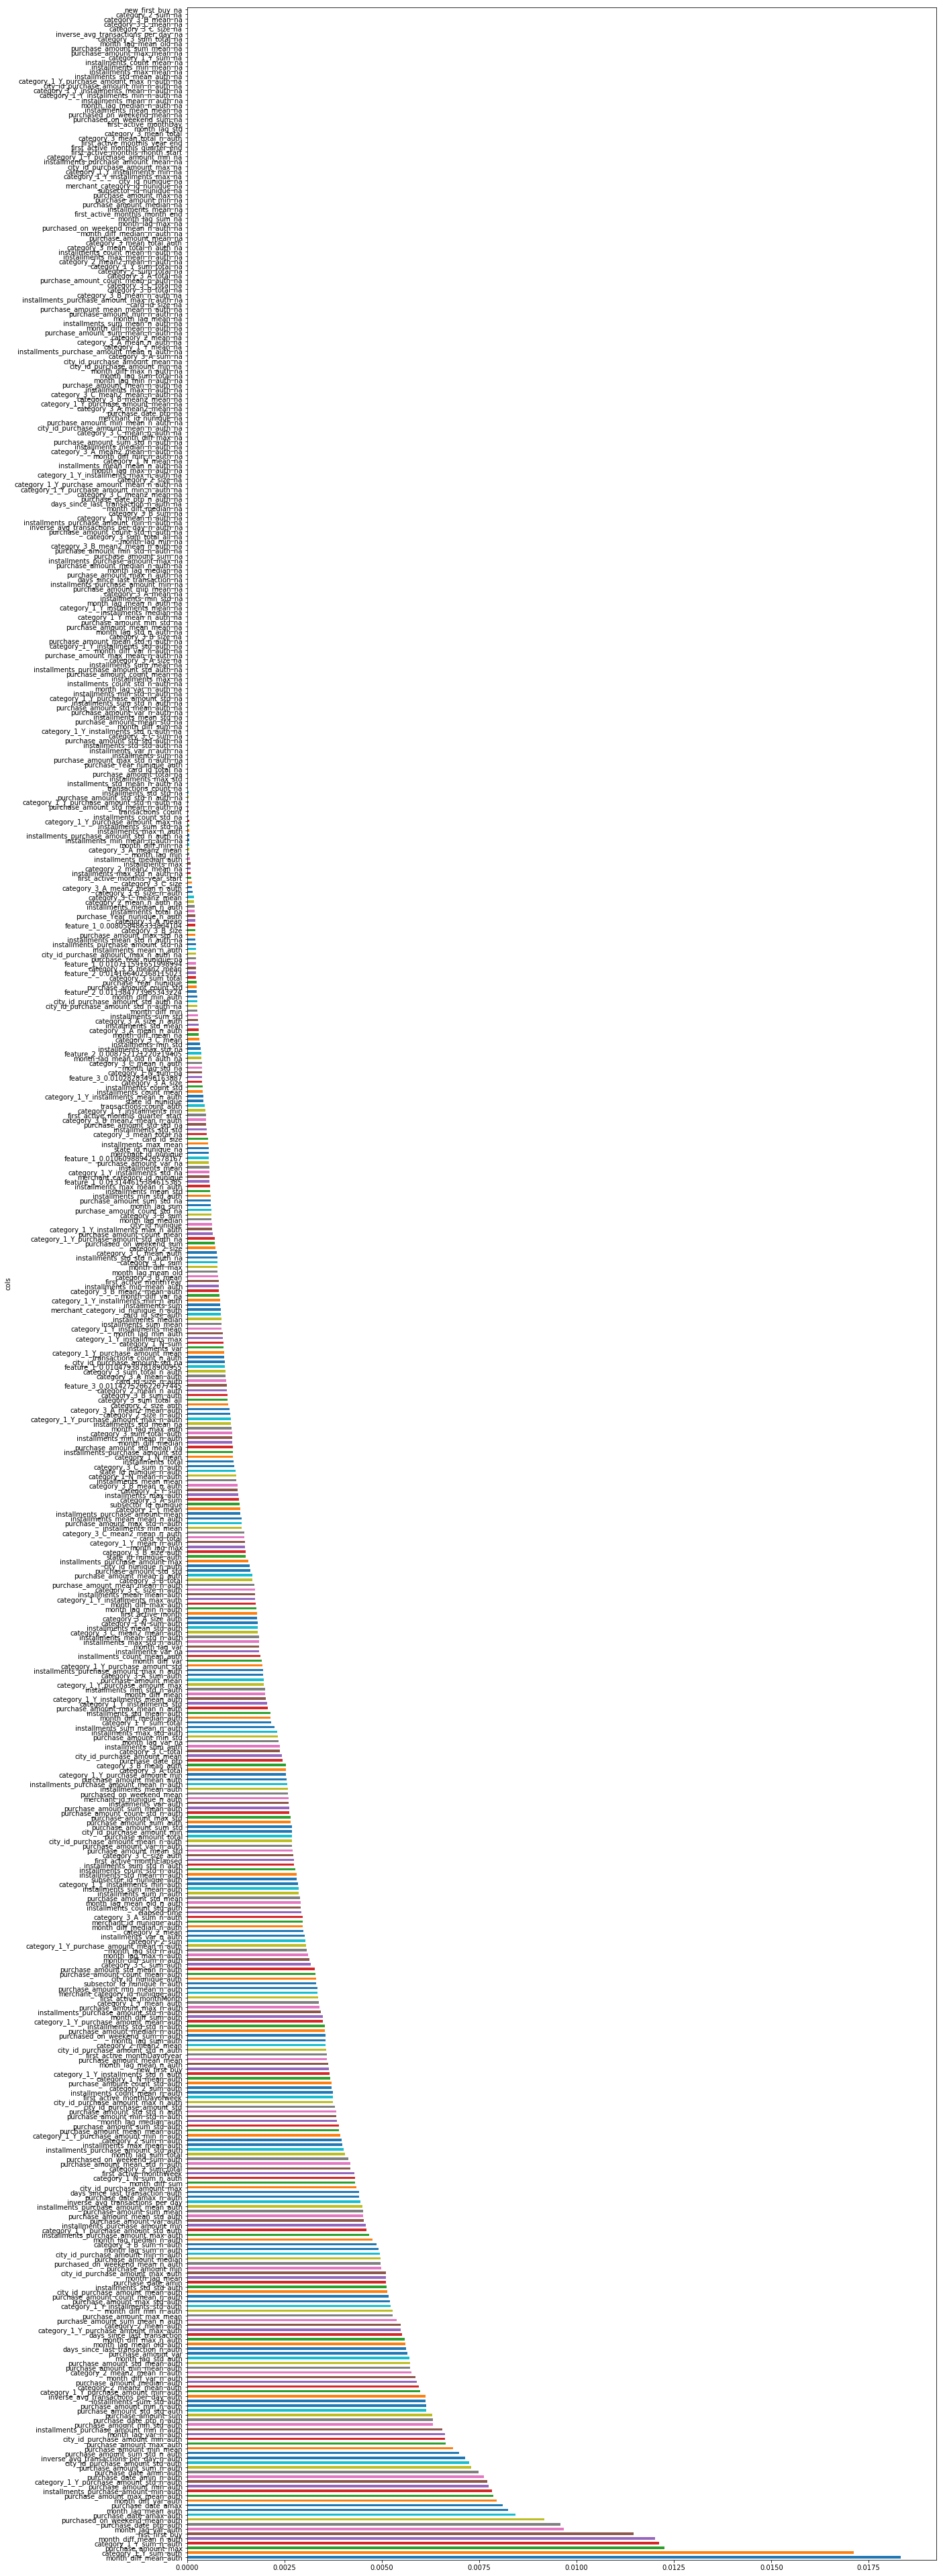

In [96]:
plot_fi(fi_hot)

In [97]:
to_keep_hot = fi_hot[fi_hot.imp>0.0025]

In [98]:
to_keep_hot.sort_values(by='imp', ascending=False)

,cols,imp
165,month_diff_mean_auth,0.018319
170,category_1_Y_sum_auth,0.017123
38,purchase_amount_max,0.012260
272,category_1_Y_sum_n_auth,0.012111
267,month_diff_mean_n_auth,0.012011
331,hist_first_buy,0.011470
154,month_lag_var_auth,0.009673
158,purchase_date_ptp_auth,0.009578
161,purchased_on_weekend_mean_auth,0.009165
157,purchase_date_amax_auth,0.008422


In [99]:
df_hot_keep = x_trn_h[to_keep_hot.cols.values]
x_val_h_keep = x_val_h[to_keep_hot.cols.values]

In [100]:
df_hot_keep.shape

(161533, 168)

In [101]:
df_hot.shape

(201917, 538)

In [102]:
set_rf_samples(20000)

In [103]:
m = RandomForestRegressor(**rf_args)
m.fit(df_hot_keep, y_trn_h)
print_score(m, df_hot_keep, y_trn_h.values, x_val_h_keep, y_val_h.values)

[3.4832143592429885, 3.792169043839099, 0.17413843020917463, 0.06419671111153535, 0.03270484501599713]


In [130]:
# reset_rf_samples()

In [84]:
m = RandomForestRegressor(**rf_args)
m.fit(df_hot_keep, y_trn_h)
print_score(m, df_hot_keep, y_trn_h.values, x_val_h_keep, y_val_h.values)

[3.467141257170407, 3.778789171806429, 0.18174263110346178, 0.07078863218665155, 0.04462439202017732]


In [104]:
fi_hot_keep = rf_feat_importance(m, df_hot_keep)

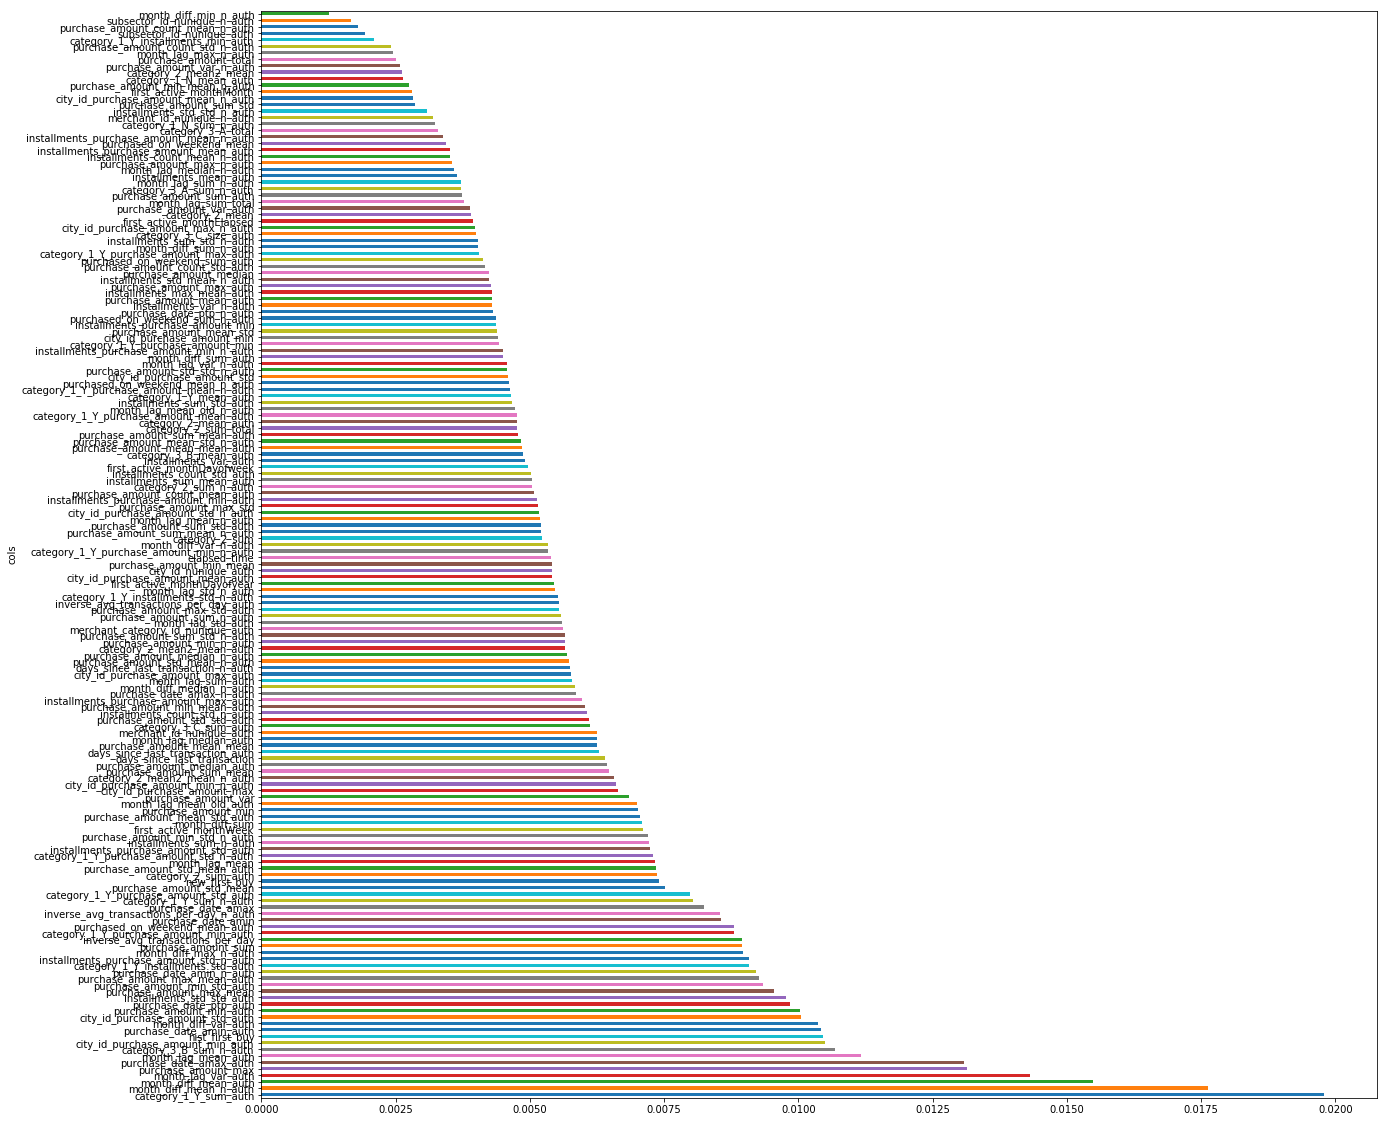

In [105]:
fi_hot_keep.plot('cols', 'imp', 'barh', figsize=(20,20), legend=False)

### Remove redundant features

In [106]:
reset_rf_samples()

In [107]:
from scipy.cluster import hierarchy as hc

In [108]:
corr = np.round(scipy.stats.spearmanr(df_hot_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

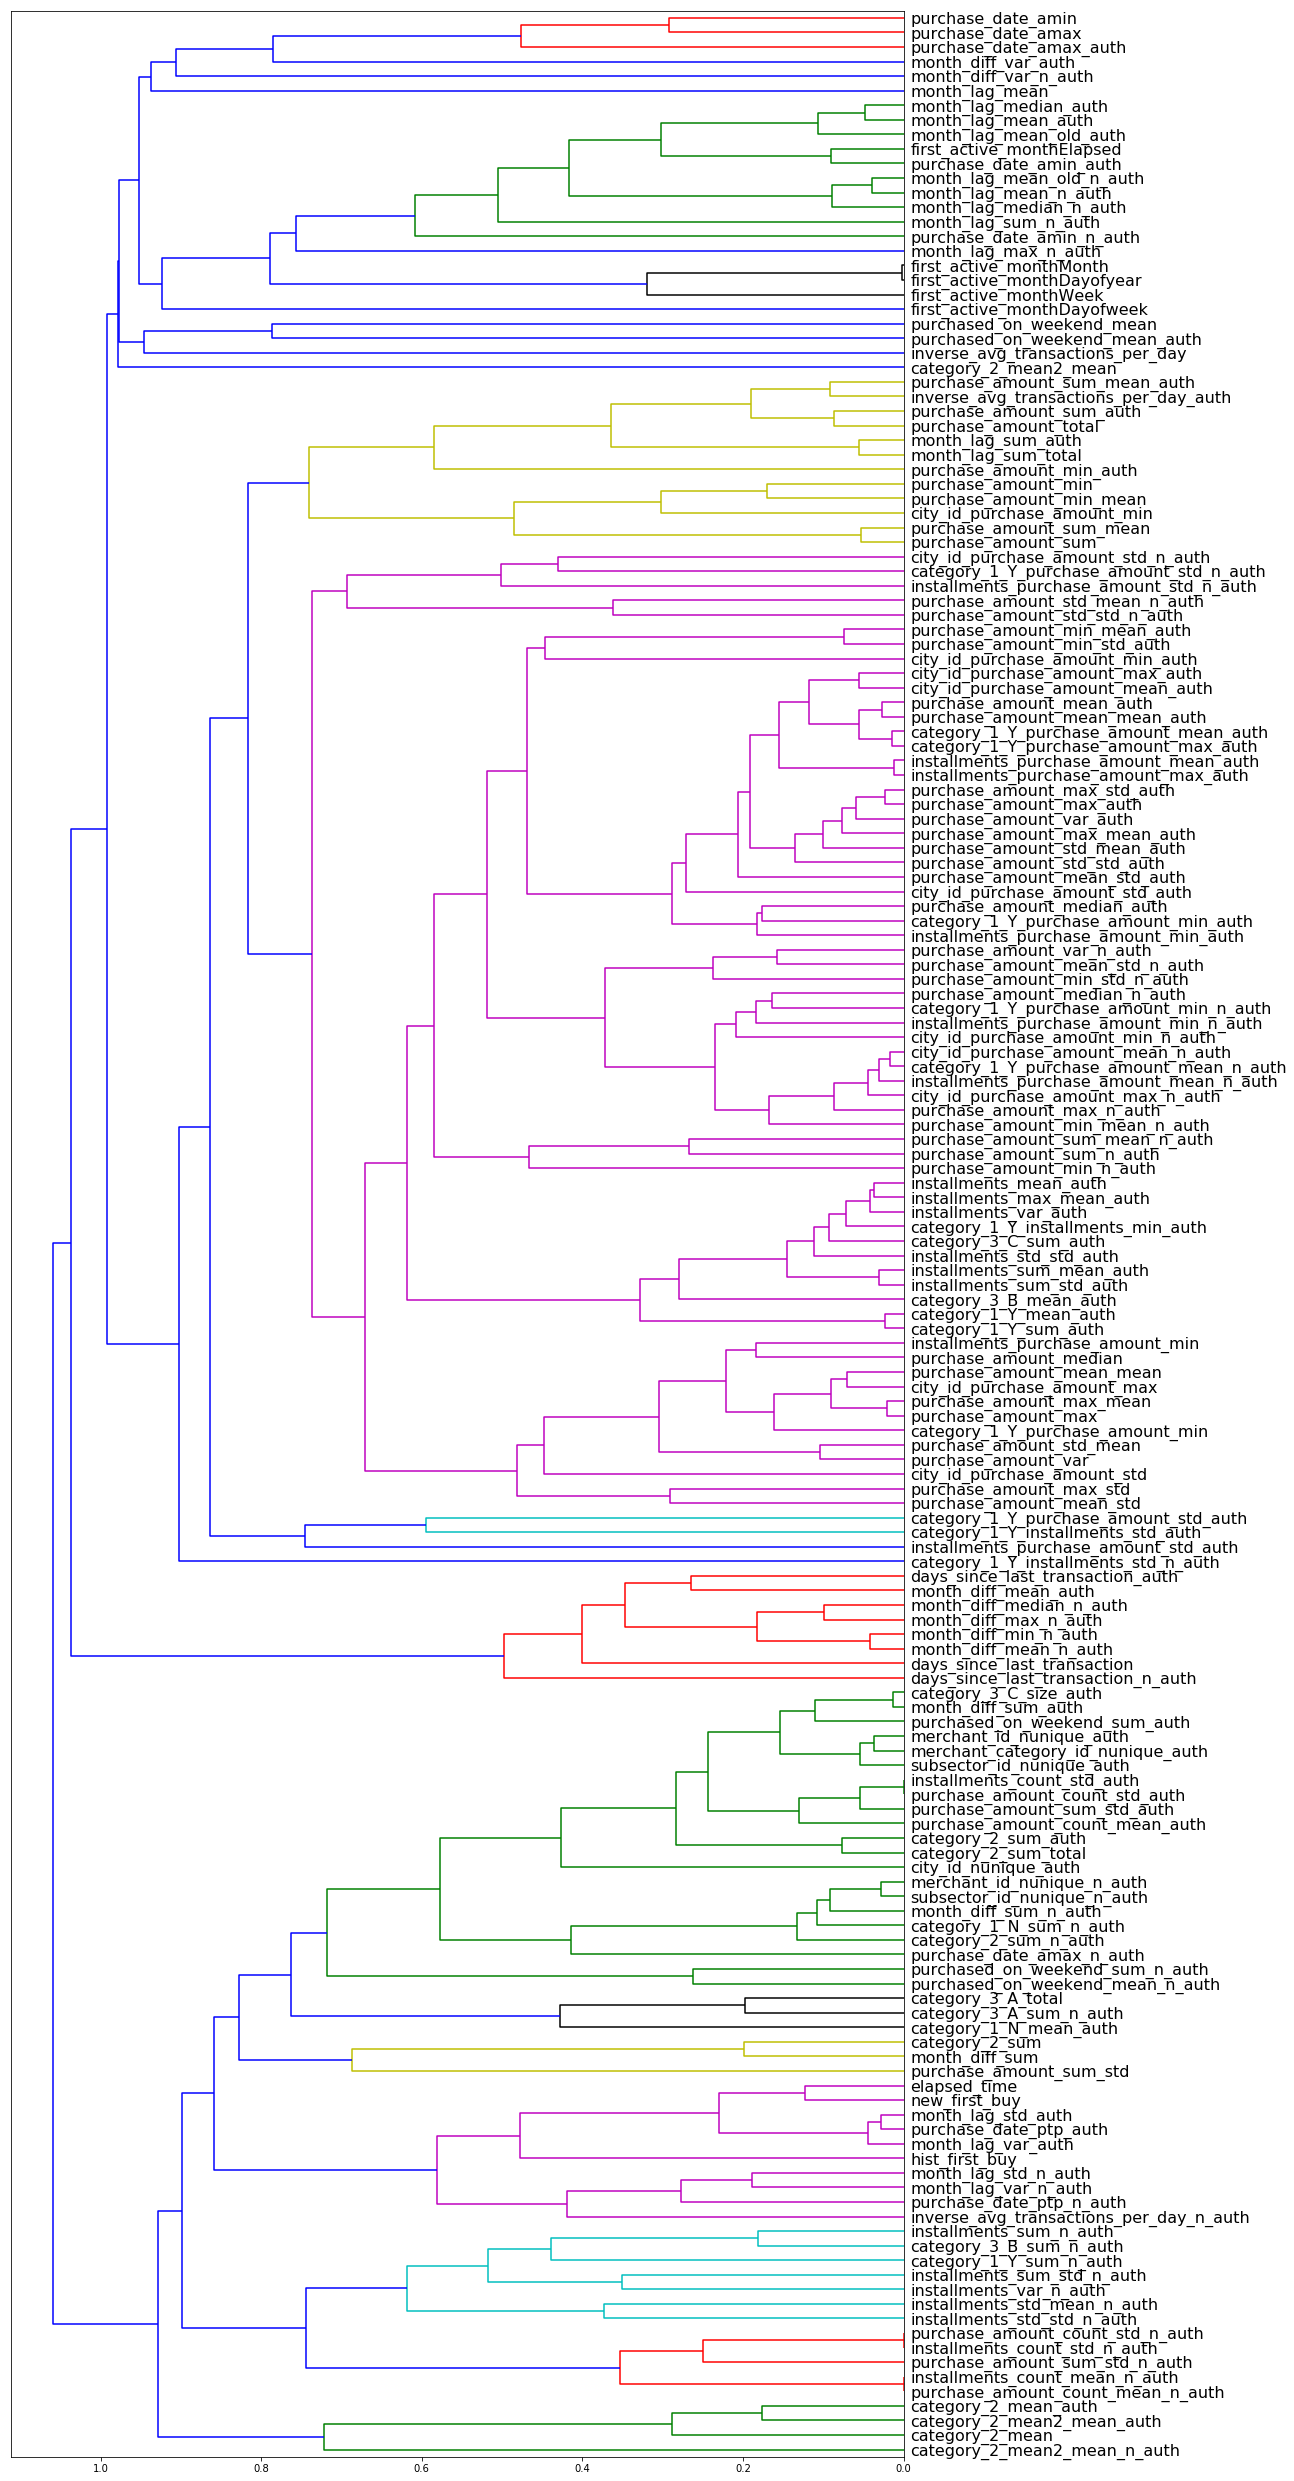

In [112]:
fig = plt.figure(figsize=(16,45))
dendrogram = hc.dendrogram(z, labels=df_hot_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [110]:
def get_oob(df, y_h):
    m = RandomForestRegressor(**rf_args)
    x, _ = split_vals(df)
    m.fit(x, y_h)
    return m.oob_score_

In [92]:
df_hot_keep.shape

(161533, 82)

In [93]:
df_hot_keep_all = df_hot[to_keep_hot.cols.values]

In [94]:
df_keep_all = df[to_keep.cols.values]

In [95]:
df_hot_keep_all.shape, y_trn_h.shape, df_keep_all.shape, y_trn_h.shape

((201917, 82), (161533,), (201917, 83), (161533,))

In [96]:
set_rf_samples(20000)

In [113]:
get_oob(df_hot_keep_all, y_trn_h)

0.04101776205690011

In [114]:
get_oob(df_keep_all, y_trn_h)

0.046611632854451024

In [99]:
df_hot_keep_all.columns.values

array(['month_diff_mean_old', 'category_1_sum_old', 'authorized_flag_mean_old', 'purchase_amount_max',
       'month_lag_mean_old', 'purchase_date_amax_old', 'category_1_mean_old', 'purchase_date_amin_old',
       'purchase_amount_min_old', 'hist_first_buy', 'purchase_date_ptp_old', 'purchase_amount_mean_old',
       'purchase_amount_max_old', 'purchased_on_weekend_mean_old', 'month_lag_sum_old',
       'inverse_avg_transactions_per_day_old', 'days_since_last_transaction', 'purchase_amount_var_old',
       'purchase_date_amax', 'purchase_amount_std_old', 'installments_mean_old', 'month_lag_var_old',
       'month_diff_var_old', 'purchase_amount_mean', 'purchase_amount_min', 'month_diff_std_old',
       'purchase_amount_sum', 'month_lag_std_old', 'days_since_last_transaction_old',
       'merchant_id_nunique_old', 'merchant_category_id_nunique_old', 'new_first_buy', 'month_lag_mean',
       'purchase_date_amin', 'installments_var_old', 'purchase_amount_var', 'purchased_on_weekend_sum_ol

In [108]:
to_remove = ['transactions_count_old', 'transactions_count', 'month_lag_var_old', 'month_lag_var',
             'month_diff_var_old', 'first_active_monthMonth', 'first_active_monthElapsed',
            'purchase_amount_var_old', 'purchase_amount_var', 'installments_var_old', 'installments_var']

In [109]:
for c in to_remove:
    print(c, get_oob(df_hot_keep_all.drop(c, axis=1), y_trn_h))

transactions_count_old 0.041168229573827486
transactions_count 0.04039561964915439
month_lag_var_old 0.04403954309360114
month_lag_var 0.04640705826992819
month_diff_var_old 0.04325788467374947
first_active_monthMonth 0.04468343481178194
first_active_monthElapsed 0.04786113991936669
purchase_amount_var_old 0.043681601585679575
purchase_amount_var 0.04545975277839487
installments_var_old 0.042334812393156285


In [110]:
to_drop = ['transactions_count_old','transactions_count', 'month_lag_var_old', 'month_lag_var',
           'first_active_monthMonth', 'first_active_monthElapsed', 'purchase_amount_var_old',
           'installments_var_old']

In [115]:
get_oob(df_hot_keep_all.drop(to_drop, axis=1), y_trn_h)

0.04317982778491747

In [116]:
df_hot_dropped = df_hot_keep.drop(to_drop, axis=1)
x_val_hot_dropped = x_val_h_keep.drop(to_drop, axis=1)

### Compare different DFs

In [123]:
m = RandomForestRegressor(**rf_args)
m.fit(df_hot_dropped, y_trn_h)
print_score(m, df_hot_dropped, y_trn_h.values, x_val_hot_dropped, y_val_h.values)

[3.4761678896149846, 3.7873172935168604, 0.17747645170209392, 0.06658973705888349, 0.04016620079346578]


In [124]:
m = RandomForestRegressor(**rf_args)
m.fit(df_hot_keep, y_trn_h)
print_score(m, df_hot_keep, y_trn_h.values, x_val_h_keep, y_val_h.values)

[3.4688082414128236, 3.787226134652933, 0.18095561381947045, 0.06663466996971878, 0.046070586584704976]


In [125]:
m = RandomForestRegressor(**rf_args)
m.fit(df_keep, y_trn)
print_score(m, df_keep, y_trn.values, x_val_keep, y_val.values)

[3.468927117408913, 3.797328604948722, 0.1808994755847707, 0.061648502487529955, 0.0439667042957802]


In [139]:
df_hot_dropped_all = df_hot[df_hot_dropped.columns.values]

In [140]:
df_hot_dropped_all.to_feather('df_hot_dropped_all')

In [141]:
df_hot_test = df_hot_test[df_hot_dropped.columns.values]

In [142]:
df_hot_test.to_feather('df_hot_test')

In [126]:
reset_rf_samples()

In [133]:
rf_args2 = dict({
    "n_estimators": 200, 
    "min_samples_leaf":35, 
    "max_features": 0.4, 
    "n_jobs":-1, 
    "oob_score":True
})

In [134]:
m = RandomForestRegressor(**rf_args2)
m.fit(df_hot_dropped, y_trn_h)
print_score(m, df_hot_dropped, y_trn_h.values, x_val_hot_dropped, y_val_h.values)

[3.413987779956741, 3.7126395277490265, 0.2066391275749614, 0.10303652576383704, 0.08816429341711762]


In [135]:
m = RandomForestRegressor(**rf_args2)
m.fit(df_hot_keep, y_trn_h)
print_score(m, df_hot_keep, y_trn_h.values, x_val_h_keep, y_val_h.values)

[3.4133752989779333, 3.7149712300053603, 0.20692376529911216, 0.10190950629248141, 0.08863679634273125]


In [136]:
m = RandomForestRegressor(**rf_args2)
m.fit(df_keep, y_trn)
print_score(m, df_keep, y_trn.values, x_val_keep, y_val.values)

[3.4123227164354146, 3.713594327862958, 0.20741281172158177, 0.10257511228900862, 0.08781376155821174]


In [137]:
m = RandomForestRegressor(**rf_args2)
m.fit(x_trn, y_trn)
print_score(m, x_trn, y_trn.values, x_val, y_val.values)

[3.412888537039359, 3.7134627431888387, 0.20714994130743192, 0.10263870850273671, 0.088112855832574]


In [132]:
x_trn.shape, df_keep.shape, df_hot_keep.shape, df_hot_dropped.shape

((161533, 139), (161533, 83), (161533, 82), (161533, 74))

### Extrapolation

In [152]:
np.floor(df_hot_dropped_all.shape[0]*.8)

161533.0

In [153]:
n_trn = 161533

In [154]:
df_ext = df_hot_dropped_all.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.796099387372039

In [156]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
13,purchased_on_weekend_mean_old,0.029818
2,authorized_flag_mean_old,0.026557
8,purchase_amount_min_old,0.026397
4,month_lag_mean_old,0.025846
12,purchase_amount_max_old,0.025597
25,month_lag_std_old,0.025588
11,purchase_amount_mean_old,0.025482
18,purchase_amount_std_old,0.024416
5,purchase_date_amax_old,0.023854
22,purchase_amount_min,0.023017


### Predict if it's a outlier

In [157]:
df_ext = df_hot_dropped_all.copy()

In [160]:
df_ext.shape, df_raw.shape

((201917, 74), (201917, 100))

In [161]:
df_ext['outlier'] = df_raw['outliers']

In [166]:
(df_ext['outlier'] == 1)[:n_trn].sum()

1746

In [167]:
(df_ext['outlier'] == 1)[n_trn:].sum()

461

In [168]:
x, y, nas = proc_df(df_ext, 'outlier')

In [190]:
m_o = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.9, n_jobs=-1, oob_score=True)
m_o.fit(x, y);
m_o.oob_score_

0.9890648137601094

In [176]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,month_diff_mean_old,0.044376
1,category_1_sum_old,0.038006
2,authorized_flag_mean_old,0.033894
7,purchase_date_amin_old,0.030239
13,purchased_on_weekend_mean_old,0.029093
25,month_lag_std_old,0.028971
4,month_lag_mean_old,0.028669
10,purchase_date_ptp_old,0.026377
5,purchase_date_amax_old,0.024220
14,month_lag_sum_old,0.023845


In [177]:
outliers_preds = m_o.predict(x)

In [178]:
outliers_preds.sum()

684

In [179]:
outliers_preds.shape

(201917,)

In [182]:
(outliers_preds != y).sum()

1523

In [184]:
df_hot_ext = df_hot_dropped_all.copy()

In [185]:
df_hot_ext['is_outlier'] = outliers_preds

In [186]:
df_hot_ext.head()

,month_diff_mean_old,category_1_sum_old,authorized_flag_mean_old,purchase_amount_max,month_lag_mean_old,purchase_date_amax_old,category_1_mean_old,purchase_date_amin_old,purchase_amount_min_old,hist_first_buy,...,month_lag_sum,installments_std,feature_2,purchased_on_weekend_sum,month_lag_std,installments_var,subsector_id_nunique,first_active_monthIs_quarter_start,city_id_nunique,is_outlier
0,10.638462,0,0.950000,-0.296112,-3.911538,1.519551e+09,0.000000,1.498573e+09,-0.739395,26,...,34.0,0.000000,0.008752,6.0,0.510754,0.000000,10.0,False,3.0,0
1,11.591429,31,0.968571,-0.701858,-5.031429,1.517438e+09,0.088571,1.483720e+09,-0.742400,5,...,9.0,0.000000,0.011385,0.0,0.547723,0.000000,4.0,True,1.0,0
2,10.558140,0,0.953488,-0.700326,-8.604651,1.519759e+09,0.000000,1.484123e+09,-0.730138,163,...,2.0,0.000000,0.008752,1.0,0.500000,0.000000,1.0,False,1.0,0
3,10.532468,12,1.000000,-0.566740,-2.831169,1.519818e+09,0.155844,1.506443e+09,-0.740897,25,...,12.0,0.755929,0.014166,3.0,0.487950,0.571429,5.0,False,2.0,0
4,10.556391,15,0.962406,0.450886,-1.285714,1.519850e+09,0.112782,1.510445e+09,-0.746156,11,...,56.0,0.376913,0.014166,12.0,0.503953,0.142063,10.0,False,5.0,0


In [187]:
x_trn_h, x_val_h = split_vals(df_hot_ext)
y_trn_h, y_val_h = split_vals(target)

In [188]:
m = RandomForestRegressor(**rf_args2)
m.fit(x_trn_h, y_trn_h)
print_score(m, x_trn_h, y_trn_h.values, x_val_h, y_val_h.values)

[3.050760368763221, 3.2802222117242863, 0.3664760390616706, 0.2998102966165297, 0.27822820106910373]


In [189]:
df_hot_test.shape

(123623, 74)

In [192]:
fi = rf_feat_importance(m, x_trn_h); fi[:10]

,cols,imp
74,is_outlier,0.610101
0,month_diff_mean_old,0.026143
3,purchase_amount_max,0.020553
5,purchase_date_amax_old,0.014710
1,category_1_sum_old,0.011268
45,month_diff_mean,0.011113
16,days_since_last_transaction,0.010376
10,purchase_date_ptp_old,0.009983
43,purchase_amount_std,0.009838
24,purchase_amount_sum,0.009598


In [193]:
test_outlier_preds = m_o.predict(df_hot_test)

In [194]:
test_outlier_preds.shape

(123623,)

In [197]:
df_hot_test_ext = df_hot_test

In [198]:
df_hot_test['is_outlier'] = test_outlier_preds

In [200]:
df_hot_test_ext.shape

(123623, 75)

In [201]:
df_hot_test_ext.to_feather('df_hot_test_ext')
df_hot_ext.to_feather('df_hot_ext')

In [202]:
m.predict(df_hot_test_ext)

array([-1.26654, -0.25684, -1.39224, ...,  0.38734, -2.4277 ,  0.07029])

In [203]:
df_outliers = df_raw.loc[df_raw['outliers'] == 1]